# FFNN Binary Classifier

## Import Libraries

In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import glob
import datetime
from tensorflow.python.framework.ops import reset_default_graph
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import sklearn as skl
from sklearn.cluster import KMeans
import os
import subprocess
import itertools
import random as rnd
#import data_utils
import pdb
import os
import sys
from scipy import signal
sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
                                         # libraries, like utils.py
import utils # contain various helper funcitons that aren't 
             # important to understand

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[int(row), int(col)] = 1
    return out

## Load, Process Data and Define Auxiliary Functions

In [6]:
FILENAME = 'Data/ffnn_dataset.csv'
df = pd.read_csv(FILENAME)

In [7]:
def period_avg(data, days):
    samples_per_day = 48
    datan = np.reshape(data[:,:int(data.shape[1]//(samples_per_day*days))*samples_per_day*days,None],(data.shape[0],days*samples_per_day,-1))
    data_avg = np.mean(datan,2)
    data_std = np.std(datan,2)
    return data_avg, data_std

def period_reshape(data, days):
    samples_per_day = 48
    datan = np.reshape(data[:,:int(data.shape[1]//(samples_per_day*days))*samples_per_day*days],(-1,days*samples_per_day))
    return datan

def fft_data_generator(df):
    # Split data into TU and non TU.
    datan = df.values[df.values[:,-1]==1,1:-2]
    datad = df.values[df.values[:,-1]==0,1:-2]
    # Average over days
    days = 7
    datan, datan_std = period_avg(datan, days)
    datad, datad_std = period_avg(datad, days)
    # Normalize data
    datan = (datan-np.mean(np.concatenate([datan,datad])))/np.std(np.concatenate([datan,datad]))
    datad = (datad-np.mean(np.concatenate([datan,datad])))/np.std(np.concatenate([datan,datad]))
    # Training dataset
    N_test = np.round(0.1*datan.shape[0]).astype(int) # Number of samples in the validation without TU
    D_test = np.round(0.1*datad.shape[0]).astype(int) # Number of samples in the validation with TU
    N_train = datan.shape[0]-N_test # Number of samples in the training without TU
    D_train = datad.shape[0]-D_test # Number of samples in the training with TU
    # Take N_train values from datan randomly, and store the indexes
    itn = np.asarray(rnd.sample(set(np.arange(0,datan.shape[0])),N_train))
    ivn = np.setxor1d(np.arange(0,datan.shape[0]), itn)  # Validation
    # Take D_train values from datad randomly, and store the indexes
    itd = np.asarray(rnd.sample(set(np.arange(0,datad.shape[0])),D_train))
    ivd = np.setxor1d(np.arange(0,datad.shape[0]), itd)  # Validation
    # Calculate FFT
    FFT_n = np.fft.fft(datan)
    FFT_d = np.fft.fft(datad)
    # Take half of the spectrum
    FFT_n = FFT_n[:,0:np.round(datan.shape[1]/2).astype(int)]
    FFT_d = FFT_d[:,0:np.round(datad.shape[1]/2).astype(int)]
    # Take training and validation samples using calculated indexes
    FFT_train = np.concatenate((FFT_n[itn,:],FFT_d[itd,:]),0)
    FFT_test = np.concatenate((FFT_n[ivn,:],FFT_d[ivd,:]),0)
    # Label with 0 non-TU and 1 TU
    label_train = np.zeros((N_train+D_train))
    label_train[N_train:] = 1
    label_test = np.zeros((N_test+D_test))
    label_test[N_test:] = 1
    
    train = FFT_train
    train_labels = label_train
    test = FFT_test
    test_labels = label_test
    
    return train, train_labels, test, test_labels
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
train, train_labels, test, test_labels = fft_data_generator(df)

In [9]:
NUM_CLASSES = 2
NUM_FEATURES = int(train.shape[1])

## KMeans and Logistic regression for comparisson.

In [10]:
# Kmeans
km = KMeans(init='k-means++', n_clusters=NUM_CLASSES, n_init=100)
km.fit(np.abs(train))
# Logistic
logis = LogisticRegression(penalty='l2',class_weight='balanced')
logis.fit(np.abs(train),train_labels)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.07  0.93]]


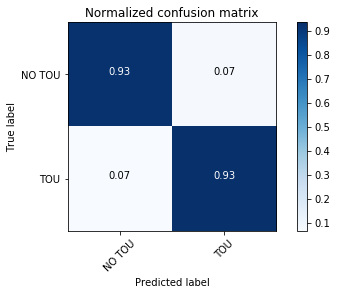

In [11]:
# Confusion matrix for logistic
cnf_matrix = skl.metrics.confusion_matrix(test_labels, logis.predict(np.abs(test)))
np.set_printoptions(precision=2)

class_names = ['NO TOU','TOU']
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
metrics.homogeneity_score(train_labels, logis.predict(train))
#plt.savefig('conf_matrix_logit.pdf',dpi = 300)
plt.show()

Normalized confusion matrix
[[ 0.03  0.97]
 [ 0.    1.  ]]


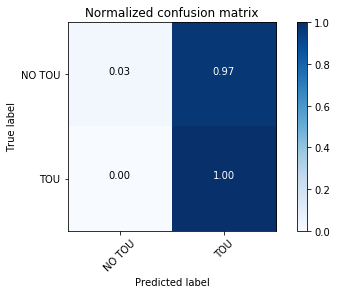

In [13]:
# Confusion matrix fo Kmeans
cnf_matrix = skl.metrics.confusion_matrix(test_labels, 1-km.predict(np.abs(test)))
np.set_printoptions(precision=2)
class_names = ['NO TOU','TOU']
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
metrics.homogeneity_score(train_labels, logis.predict(train))
#plt.savefig('conf_matrix_kmeans.pdf',dpi = 300)
plt.show()

## Visualize Data

In [14]:
# Spectrogram
# Split data into TU and non TU.
datan = df.values[df.values[:,-1]==1,1:-2]
datad = df.values[df.values[:,-1]==0,1:-2]
# Normalize data
datan = (datan-np.mean(np.concatenate([datan,datad])))/np.std(np.concatenate([datan,datad]))
datad = (datad-np.mean(np.concatenate([datan,datad])))/np.std(np.concatenate([datan,datad]))
f,t,Sxx = signal.spectrogram(datad,window=('tukey',0.25),nperseg = 48*30,axis=-1)

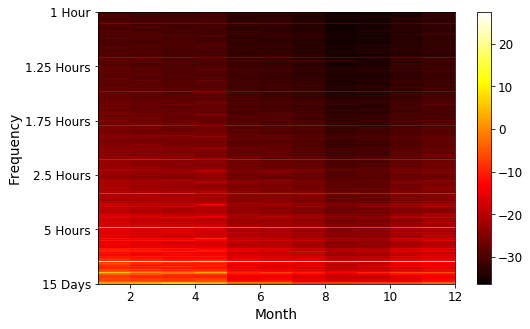

In [15]:
# Visualize Spectrogram
scale = 0.6
mpl.rcParams['ytick.labelsize']=20*scale
mpl.rcParams['xtick.labelsize']=20*scale
mpl.rcParams['axes.labelsize']=23*scale
mpl.rcParams['axes.titlesize']=23*scale
mpl.rcParams['legend.fontsize']=15*scale
plt.figure(figsize=(8, 5))
plt.pcolormesh(np.arange(1,t.shape[0]), f, 20*np.log10(np.mean(Sxx[:,:,:-1], axis = 0)))
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.yticks(np.arange(0,0.6,0.1),['15 Days','5 Hours','2.5 Hours','1.75 Hours','1.25 Hours','1 Hour'])
plt.set_cmap('hot')
plt.colorbar()
plt.show()
#plt.savefig('tou.pdf',dpi=400)
plt.tight_layout()

## Build the model

In [16]:
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, batch_norm, max_pool2d, dropout
from tensorflow.python.ops.nn import relu, elu, relu6, sigmoid, tanh, softmax
from tensorflow.python.ops.nn import dynamic_rnn

In [17]:
# resetting the graph ...
reset_default_graph()
l1_units = 32
l2_units = 64
# Setting up placeholder, this is where your data enters the graph!
x_fft_pl = tf.placeholder(tf.float32, [None, NUM_FEATURES], name="x-fft_pl")
is_training_pl = tf.placeholder(tf.bool, name="is-training_pl")
class_weight = [(train_labels == 1).sum()/len(train_labels),1-(train_labels == 1).sum()/len(train_labels)]
# use fft
features = tf.concat(values=[x_fft_pl], axis=1, name="features")
features = batch_norm(features, scope='features_bn')
l1 = fully_connected(features, num_outputs=l1_units, activation_fn=relu,
                    normalizer_fn=batch_norm, scope="l1")
#l2 = fully_connected(l1, num_outputs=l2_units, activation_fn=relu,
#                    normalizer_fn=batch_norm, scope="l2")
#l2_dropout = dropout(l2, is_training=is_training_pl, scope="l2_dropout")
y = fully_connected(l1, NUM_CLASSES, activation_fn=softmax, scope="y")

# add TensorBoard summaries for all variables
tf.summary.merge_all()

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))

In [18]:
## Launch TensorBoard, and visualize the TF graph
tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
utils.show_graph(tmp_def)

In [19]:
# PRINT NETWORK (good practice to also include outcommented code when using it)
print("x_fft_pl,", x_fft_pl.get_shape())
print("y,", y.get_shape())
# for the MLP
print("l1,", l1.get_shape())
print("l2,", l2.get_shape())

x_fft_pl, (?, 168)
y, (?, 2)
l1, (?, 32)


NameError: name 'l2' is not defined

## Build the cost function

In [20]:
clip_norm = 1
ts_pl = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="targets_pl")
lr_pl = tf.placeholder(tf.float32, [], name="learning_rate_pl")
def loss_and_acc(preds):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(class_weight * ts_pl * tf.log(preds+1e-10), reduction_indices=[1])
    # averaging over samples
    loss = tf.reduce_mean(cross_entropy)
    # if you want regularization
    reg_scale = 0.0001
    regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    reg_term = sum([regularize(param) for param in params])
    loss += reg_term
    # calculate accuracy
    argmax_y = tf.to_int32(tf.argmax(preds, axis=1))
    argmax_t = tf.to_int32(tf.argmax(ts_pl, axis=1))
    correct = tf.to_float(tf.equal(argmax_y, argmax_t))
    accuracy = tf.reduce_mean(correct)
    return loss, accuracy, argmax_y

### loss, accuracy and prediction
loss, accuracy, prediction = loss_and_acc(y) 

# defining our optimizer
LEARNING_RATE = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

# applying the gradients
grads_and_vars = optimizer.compute_gradients(loss)
gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
clipped_gradients, global_norm = (
    tf.clip_by_global_norm(gradients, clip_norm) )
clipped_grads_and_vars = zip(clipped_gradients, variables)

# make training op for applying the gradients
train_op = optimizer.apply_gradients(clipped_grads_and_vars)

# make tensorboard summeries
tf.summary.scalar('global_gradient_norm', global_norm)
tf.summary.scalar('Evaluation/loss', loss)
tf.summary.scalar('Evaluation/accuracy', accuracy)

# initialize the Session again to add the new operations
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.global_variables_initializer())

In [21]:
#Test the forward pass
_feature_shape = (45, NUM_FEATURES)
_x_shape = np.random.normal(0, 1, _feature_shape).astype('float32')
# test the forward pass
sess.run(tf.global_variables_initializer())
feed_dict = {x_fft_pl: _x_shape,
             is_training_pl: False}
res_forward_pass = sess.run(fetches=[y], feed_dict=feed_dict)
print("y", res_forward_pass[0].shape)

y (45, 2)


In [22]:
# This cell runs tensorboard in the background which means it can be watched live while training
# Go to http://your.ip.address:6006 in order to see the tensorboard
import subprocess
subprocess.Popen(["tensorboard","--logdir=tensorboard"])

## Training

In [23]:
#Training Loop
BATCH_SIZE = 1024
ITERATIONS = int(1e4)
LOG_FREQ = 10
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for valition
SEED = 42
DROPOUT = True
VALID_EVERY = 100


sss = StratifiedShuffleSplit(n_splits=ITERATIONS,test_size=VALIDATION_SIZE,random_state=SEED)

# setup and write summaries
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summaries_path = "tensorboard/%s" % (timestamp)
summaries = tf.summary.merge_all()

summarywriter_train = tf.summary.FileWriter(summaries_path + '/train', sess.graph)
summarywriter_valid = tf.summary.FileWriter(summaries_path + '/valid', sess.graph)
conv_count = 0

train_loss = []
train_acc = []
num = 0
print("\ttrain_loss \ttrain_acc \tvalid_loss \tvalid_acc")

try:
    for i, (train_idx,val_idx) in enumerate(sss.split(train,train_labels)):
        if i>=ITERATIONS:
            break
        fetches_train = [train_op, loss, accuracy, summaries]
        
        x_shape_value = train[train_idx,:]
        ts_value = train_labels[train_idx]
        ts_value = onehot(ts_value,NUM_CLASSES)
        
        feed_dict_train = {
            x_fft_pl: x_shape_value,
            ts_pl: ts_value,
            is_training_pl: DROPOUT,
            lr_pl: LEARNING_RATE,
        }
        res_train = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        if i % LOG_FREQ == 0:
            summarywriter_train.add_summary(res_train[3], i)
        train_loss.append(res_train[1])
        train_acc.append(res_train[2])
        if len(train_acc)>4:
            if np.abs(train_acc[-1]-train_acc[-2])<1e-4:
                conv_count += 1
                if conv_count == 10:
                    print("Convergence reached")
                    break
            else:
                conv_count = 0
        # validate
        if i % VALID_EVERY == 0:
            num +=1
            cur_acc = 0
            cur_loss = 0
            tot_num = 0
            # batch validation
                # fetches and feed_dict for validation
            fetches_valid = [loss, accuracy, summaries]
            
            x_shape_value_val = train[val_idx,:]
            ts_value_val = train_labels[val_idx]
            ts_value_val = onehot(ts_value_val,NUM_CLASSES)
            
            feed_dict_valid = {
                x_fft_pl: x_shape_value_val,
                ts_pl: ts_value_val,
                is_training_pl: False,
            }
            # run validation
            res_valid = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
            # tensorboard and costs
            cur_loss += res_valid[0]*num   # Validation loss
            cur_acc  += res_valid[1]*num   # Validation accuracy 
            summarywriter_valid.add_summary(res_valid[2], i) # save the vali summary
            tot_num += num

            valid_loss = cur_loss / float(tot_num)
            valid_acc = (cur_acc / float(tot_num)) * 100
            train_loss = sum(train_loss) / float(len(train_loss))
            train_acc = sum(train_acc) / float(len(train_acc)) * 100
            print("%d:\t  %.2f\t\t  %.1f\t\t  %.2f\t\t  %.1f" % (i, train_loss, train_acc, valid_loss, valid_acc))
            train_loss = []
            train_acc = []
except KeyboardInterrupt:
    pass

	train_loss 	train_acc 	valid_loss 	valid_acc


/home/dicano/.local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


0:	  0.30		  39.9		  0.26		  52.5
Convergence reached


## TEST

In [24]:
fetches_test = [y]
x_shape_value = test
feed_dict_test = {
    x_fft_pl: x_shape_value,
    ts_pl: ts_value,
    is_training_pl: False,
    }
# get the result
res_test = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
y_out = res_test[0]

/home/dicano/.local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Test Accuracy: 95.3


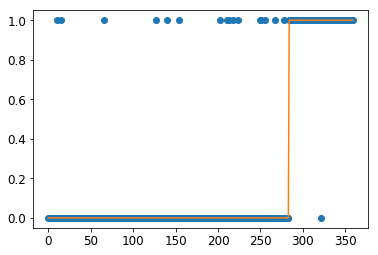

In [25]:
plt.figure()
plt.plot(np.round(y_out)[:,1],'o')
plt.plot(test_labels)
print('Test Accuracy: %.1f'% (np.sum(np.round(y_out)[:,1]==test_labels)/test_labels.shape[0]*100))

Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.01  0.99]]


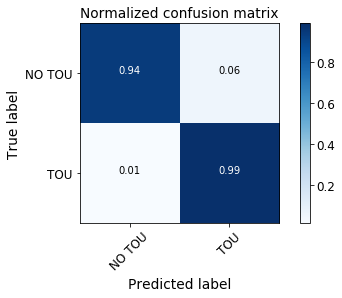

In [27]:
# Compute confusion matrix
cnf_matrix = skl.metrics.confusion_matrix(test_labels, np.round(y_out)[:,1])
np.set_printoptions(precision=2)

class_names = ['NO TOU','TOU']

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


#plt.savefig('conf_mat.pdf')

# LSTM

## Import necessary Libraries

In [1]:
%matplotlib inline
from keras.models import Sequential
import keras
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization,LeakyReLU
from keras.layers.recurrent import LSTM
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from keras import optimizers
from keras.models import load_model

from IPython.display import clear_output
import pandas as pd
import numpy as np
import pdb, time
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.
/Applications/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Define callbacks for training

In [2]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        plt.figure(figsize=(50,10))
        plt.ylim([0,max(max(self.val_losses[-20:]),max(self.losses[-20:]))])
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

In [3]:
def load_data(filename,tof, window,test_pct=0.9, normalize_data = True):
    if tof:
        data = pd.read_csv(filename,usecols= ['tof','tariff'])
        data['next_day_tariff'] = data['tariff'][48:].reset_index(drop=True)
        data = data[data['next_day_tariff'].notnull()].as_matrix()
    else:
        data = pd.read_csv(filename,usecols= ['no_tof']).as_matrix()
        
    num_features = data.shape[1]
    sequence_length = window + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    test = result[int(row):,:]
#     pdb.set_trace()
    if normalize_data:
        m_mean = data[0:int(row),0].mean()
        m_std = data[0:int(row),0].std()
        train[:,:,0] -= m_mean
        train[:,:,0] /= m_std
    else:
        m_mean = 0
        m_std = 1
        
    x_train = train[:, :-1]
    y_train = train[:, -1][:,0]
    x_test = test[:, :-1]
    y_test = test[:, -1][:,0]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_features))
    y_train = np.reshape(y_train,(y_train.shape[0],1))
    y_test = np.reshape(y_test,(y_test.shape[0],1))
    
    return [x_train, y_train, x_test, y_test, m_mean, m_std]

def build_model(shape,hl,batch_size):
    window = shape[0]
    features = shape[1]
    ml = len(hl)>1 #boolean multiple layers
    d = DROPOUT_PCT
    model = Sequential()
    
    model.add(LSTM( hl[0], input_shape=(window, features), return_sequences=ml))
    model.add(Dropout(d))

    if  ml: #multiple layers
        for i in range(1,len(hl)-1):
            model.add(LSTM(hl[i-1], return_sequences=True))
            model.add(Dropout(d))
        model.add(LSTM(hl[-1], return_sequences=False))
        model.add(Dropout(d))

    model.add(Dense(1))
    model.add(Activation('linear'))

    model.compile(loss=LOSS_FUNCTION,optimizer=OPTIMIZER)
    model.summary()
    return model

def evaluate_model_and_predict(X_train,y_train,X_test,y_test,model,m_mean,m_std):
    Scaled_X_test = np.copy(X_test)
    Scaled_y_test = np.copy(y_test)
    Scaled_X_test[:,:,0] -= m_mean
    Scaled_X_test[:,:,0] /= m_std
    Scaled_y_test -= m_mean
    Scaled_y_test /= m_std
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(Scaled_X_test, Scaled_y_test, verbose=0) 
    
    p = model.predict(Scaled_X_test)*m_std + m_mean
    with open('performance_'+model_name+'.txt','w') as f:
        f.write('\nTrain Score: %s MSE (%s RMSE)' % (train_score, math.sqrt(train_score)))
        f.write('\nTest Score: %s MSE (%s RMSE)' % (test_score, math.sqrt(test_score)))
        f.write('\nFinished in %d hours %02d minutes %02d seconds'%(h, m, s))
    show_start = 0
    show_end = -1
    plt.figure(figsize=(50,10))
    plt.plot(p[show_start:show_end],color='red', label='prediction')
    plt.plot(y_test[show_start:show_end],color='blue', label='y_test')
    plt.legend(loc='upper left')

    plt.savefig('lstm_'+model_name+'.eps', format='eps')
    plt.show()
    return p

In [ ]:
TOF = False # train on tof customers including tariff values
EPOCHS = 100
BATCH_SIZE = [256,512]
HIDDEN_UNITS = [50,100,200]
NUMBER_OF_LAYERS = [1,2]
DAYS_WINDOW = [1,2,7]
WINDOW = [day_window*48 for day_window in DAYS_WINDOW]
NORMALIZE_DATA = True
# BATCH_NORM = False
OPTIMIZER = optimizers.RMSprop(lr=0.01)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,epsilon = 0.01, patience=5, min_lr=1e-8,verbose=1)
LOSS_FUNCTION = 'mse'
TEST_PCT = 0.9
DROPOUT_PCT = 0.2
VALIDATION_SPLIT = 0.1
FILENAME = 'total_cons.csv'

# nl = number of layers
# hu = number of hidden units

for nl in NUMBER_OF_LAYERS:
    for hu in HIDDEN_UNITS:
        for window in WINDOW: 
            for batch_size in BATCH_SIZE:
                model_name = 'dp'+str(window)+'_nl'+str(nl)+'_hu'+str(hu)+'_bs'+str(batch_size)
                OPTIMIZER = optimizers.RMSprop(lr=0.01)
                csv_logger = CSVLogger('traininglog_'+model_name+'.csv')
                hl = [hu]* nl
                plot_losses = PlotLosses()
                callbacks = [plot_losses, reduce_lr, csv_logger]


                X_train, y_train, X_test, y_test,m_mean,m_std = load_data(FILENAME,TOF,
                                                                          window, 
                                                                          normalize_data = NORMALIZE_DATA)
                
                model = build_model(list(X_train.shape[1:]),hl,batch_size)

                start_time = time.time() #initialize time
                model.fit(
                    X_train,
                    y_train,
                    batch_size= batch_size,
                    epochs=EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    callbacks= callbacks,
                    verbose=1)
                
                elapsed_time = time.time() - start_time
                m, s = divmod(elapsed_time, 60)
                h, m = divmod(m, 60)
                
                model.save('lstm_'+model_name+'.h5')
                
                p = evaluate_model_and_predict(X_train,y_train,X_test,y_test,model,m_mean,m_std)


## Simple ARIMA forecaster for model comparison with LSTM

In [12]:
data = pd.read_csv('data/total_cons.csv',usecols= ['no_tof']).as_matrix()
train_size = int(len(X) * 0.9)
train, test = data[0:train_size], X[train_size:len(data)]
previous_cons = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(previous_cons, order=(5,0,0))
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()
    pred = prediction[0]
    predictions.append(pred)
    current_cons = test[t]
    previous_cons.append(current_cons)
    print(t)
error = mean_squared_error(test, predictions)
print('ARIMA model MSE: ', error)

ARIMA model MSE:  501.34610549


## Compute 'unnormalized' MSE for comparison with ARIMA

In [11]:
lstm_model = load_model('lstm_dp1_nl2_hu200_stFalse_bs512_300e.h5')

X_train, y_train, X_test, y_test,m_mean,m_std = load_data('Data/total_cons.csv',False,
                                                                          48, 
                                                                          normalize_data = True)

p = lstm_model.predict((X_test-m_mean)/m_std)*m_std + m_mean
error = mean_squared_error(y_test, p)
print('Best LSTM model MSE: ', error)

Best LSTM model MSE:  250.502781982
